## Cloning the repository of deepsleepnet from github into colab

In [1]:
!git clone https://github.com/akaraspt/deepsleepnet.git
!pip install mne

Cloning into 'deepsleepnet'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 150 (delta 7), reused 8 (delta 0), pack-reused 106
Receiving objects: 100% (150/150), 1.58 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (49/49), done.
     |████████████████████████████████| 6.9 MB 4.6 MB/s 


In [2]:
cd deepsleepnet/data

/content/deepsleepnet/data


In [ ]:
!chmod +x download_physionet.sh
!./download_physionet.sh


In [4]:
cd ..

/content/deepsleepnet


In [20]:
import numpy as np
import mne
import os
import time
import matplotlib.pyplot as plt

## Reading the data

In [36]:
size = 0
start = time.time()
data = {}

for i, file in enumerate(os.listdir('deepsleepnet/data')):
  if file.endswith('G.edf'):
    data_ = mne.io.read_raw_edf('deepsleepnet/data/' + file, verbose=False)
    raw_data = data_.get_data()
    data[file] = data_
    # size += os.path.getsize('deepsleepnet/data/' + file)

keys = list(data.keys())

end = time.time()
print(end-start)

110.49013447761536


## Plotting the signals from different channels for 100 time steps i.e. 1 sec

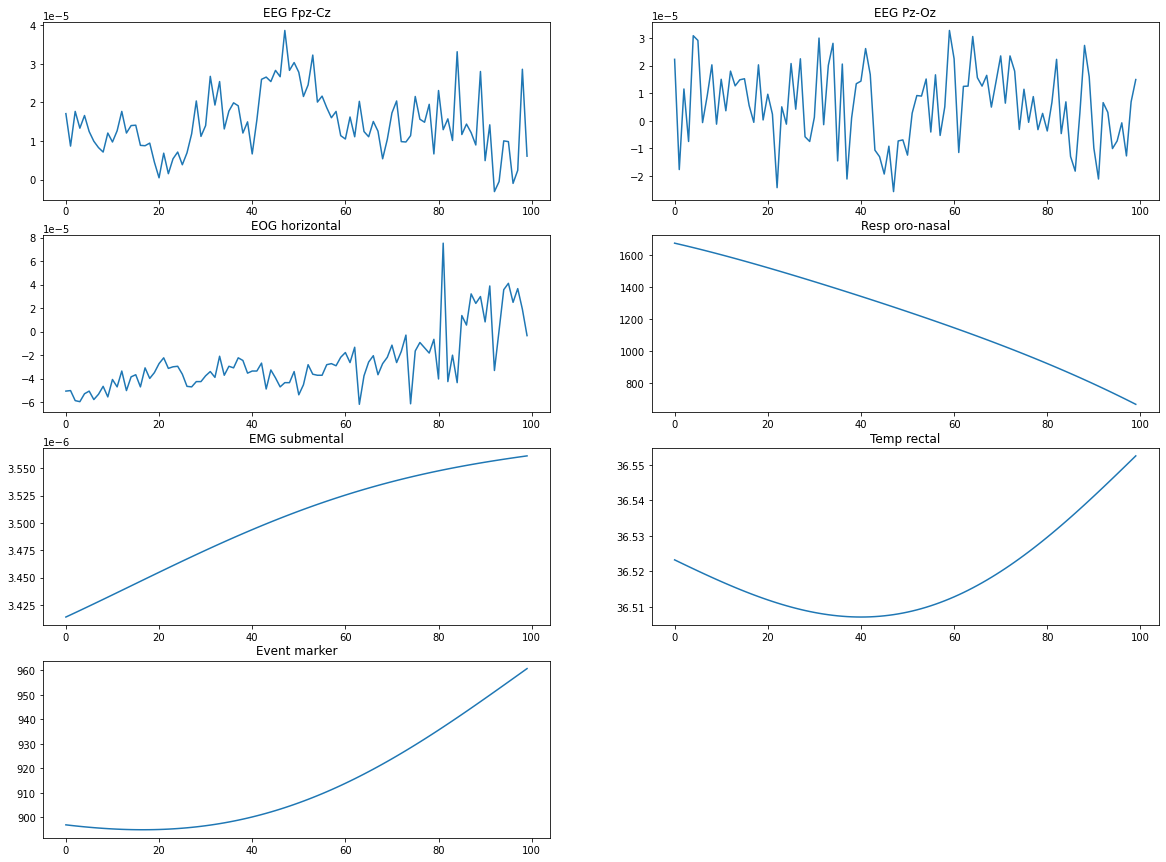

In [37]:
key = list(data.keys())[0]
channels = data[key].ch_names

plt.figure(figsize=(20, 15))
for i, (d, c) in enumerate(zip(data[key].get_data(), channels)):
  plt.subplot(4, 2, i+1)
  plt.plot(d[:100])
  plt.title(c)
plt.show()

## Function for plotting signals in time and frequency domain
**Used the Fast Fourier Transform Algorithm (FFT) from numpy library to obtain the frequency domain of signal**

**Since the time complexity of FFT is nlog(n)**

In [54]:
def plot_for_signal(data, title='', frequency=100):
  y = data
  Y = np.fft.fft(y)
  z = np.fft.fftfreq(y.shape[-1], d=1/frequency)

  plt.figure(figsize=(25, 5))
  plt.subplot(131)
  plt.plot(y[:100], color='k', label='signal in time domain')
  plt.legend(shadow=True)
  plt.suptitle(title, fontsize=30)

  for i, (signal, color, name) in enumerate(zip((Y.real, Y.imag), ('red', 'blue'), ('real frequency', 'imaginary frequency'))):
    plt.subplot(1, 3, i+2)
    plt.plot(z, signal, '-', color=color, label=name)
    plt.legend(shadow=True)
    plt.grid(True)
  plt.show()

## Function for bandpass filter

**This function uses the technique of altering the signal in frequency domain to supress selected frrequencies**
1. Get the fourier transform of signal (Used FFT).
2. Assign 0 value to the frequency components that are to be supressed.
3. Example if Y is the fourier transform of time domain signal y then Y[-90] = Y[90] = 0, removes the frequency component of 90Hz from time domain.
4. Take the inverse fourier transform of this changed Y. (Used inverse fast fourier transform)
5. Now the signal obtained is a time domain signal free of supressed frequencies.

In [39]:
def bandpass_filter(y, sf=100, lower_limit=0, upper_limit=100):
  Y = np.fft.fft(y)
  x = np.fft.fftfreq(Y.shape[-1], d=1/sf)
  Y[np.abs(x)<lower_limit] = 0
  Y[np.abs(x)>upper_limit] = 0
  y = np.fft.ifft(Y)
  return y

### Run the below cell to check the performance of bandpass_filter function

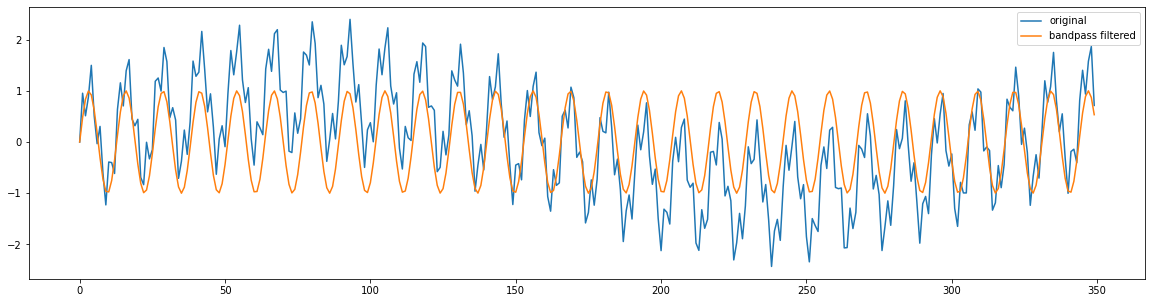

In [52]:
import warnings
warnings.filterwarnings("ignore")

x = np.arange(0, 100, np.pi/1000)
y = 0.5*np.sin(2*np.pi*100*x) + np.sin(2*np.pi*25*x) + np.sin(2*np.pi*1*x)  # Combination of frequencies 100Hz, 25Hz and 1Hz
plt.figure(figsize=(20, 5))
plt.plot(y[:350], label='original')
plt.plot(bandpass_filter(y, 1000/np.pi, 10, 30)[:350], label='bandpass filtered') # bandpass filter with 10Hz to 30Hz allowable frequency
plt.legend()
plt.show()

## Plotting the signals from different channels for **a subject** in both time and frequency domains.

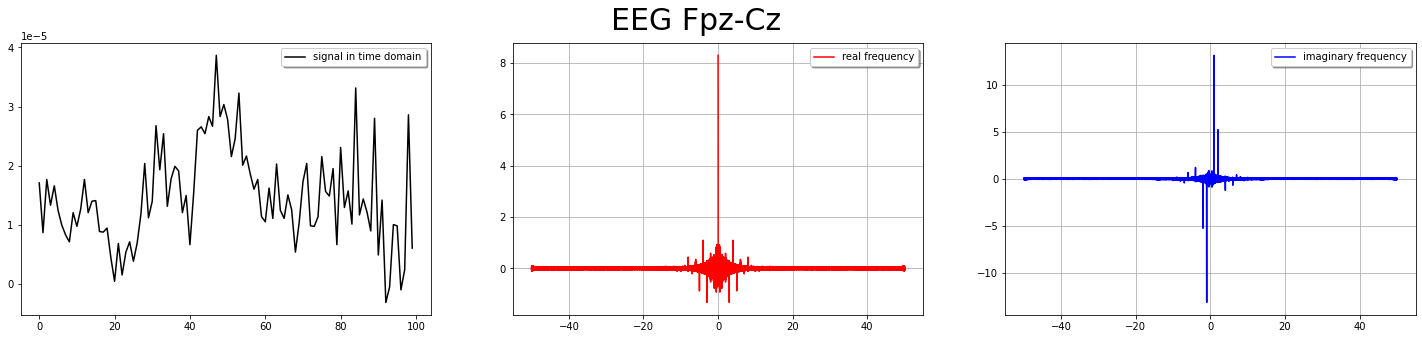

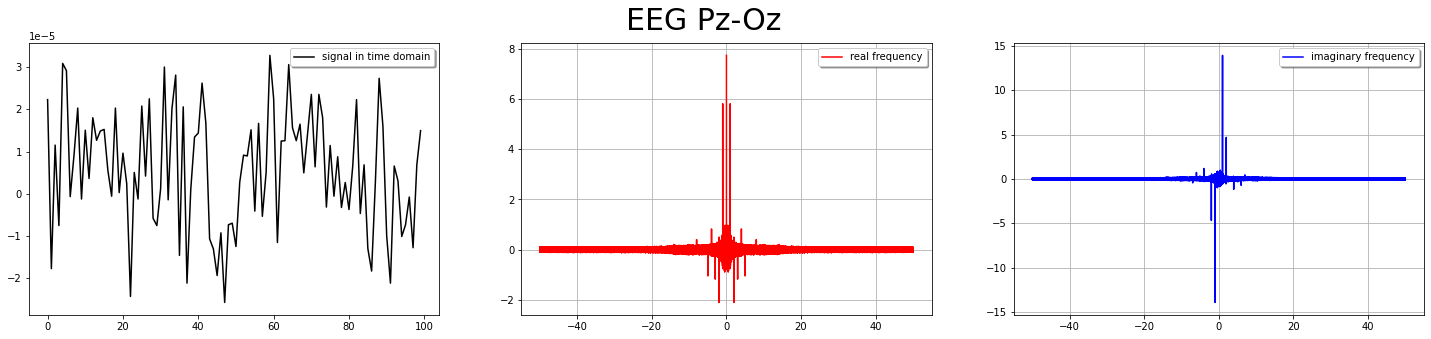

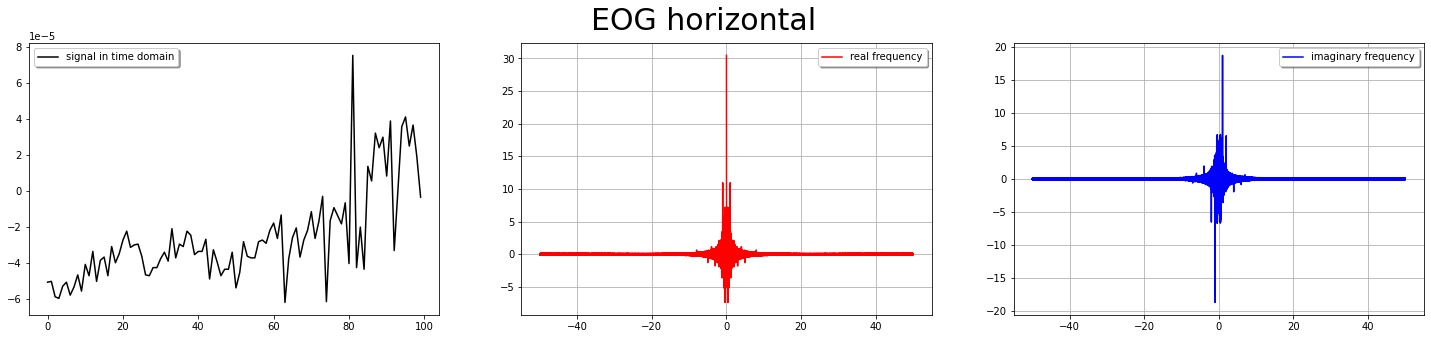

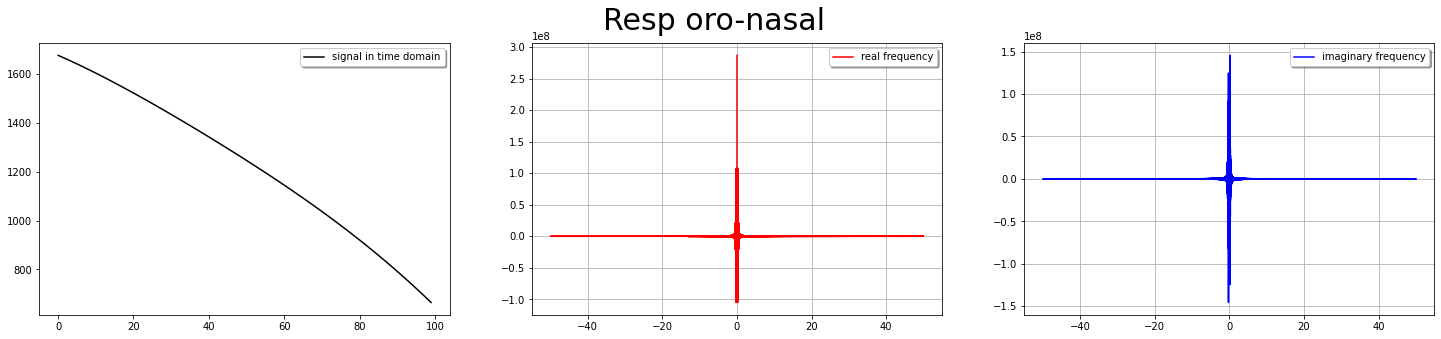

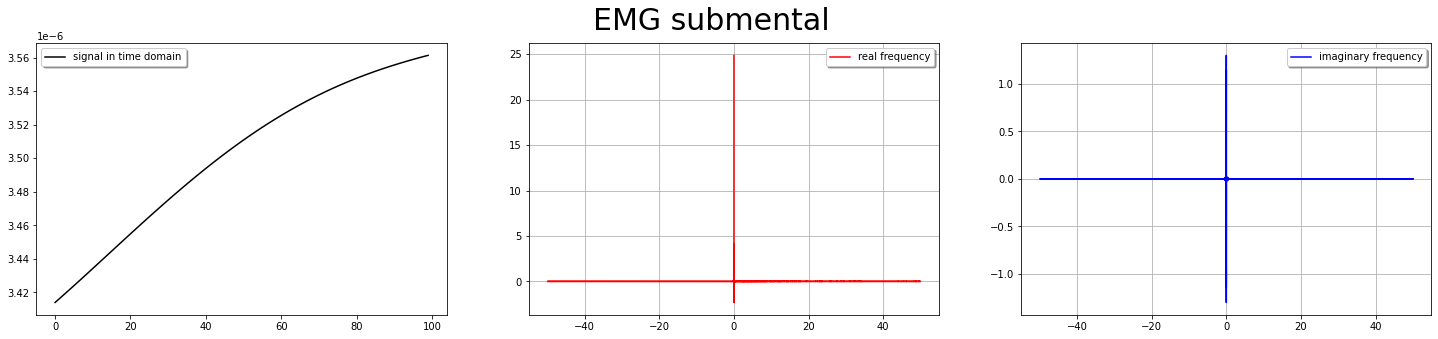

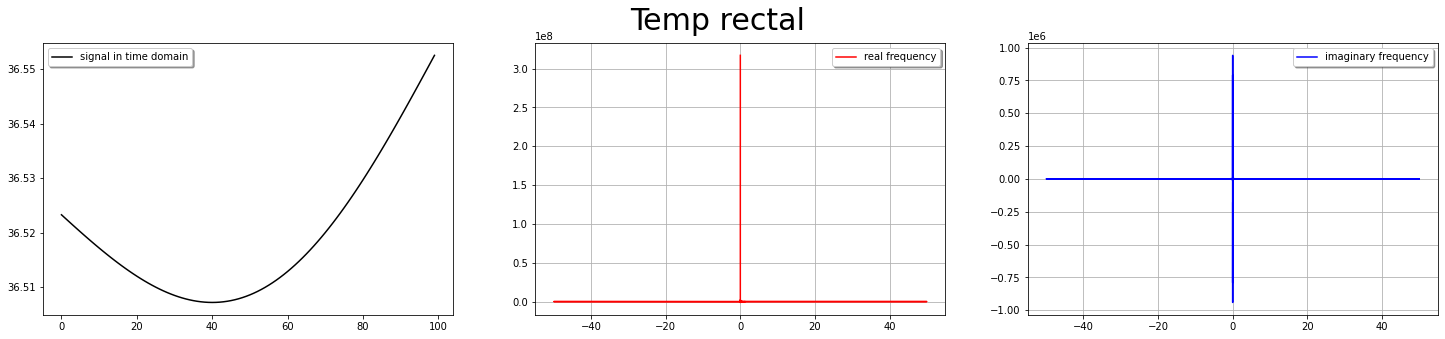

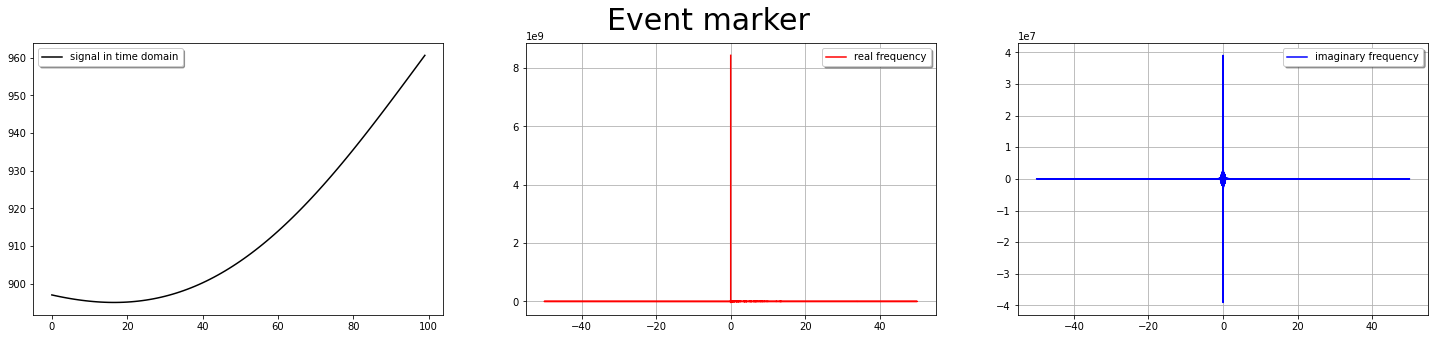

In [55]:
key = list(data.keys())[0]
channels = data[key].ch_names

for d, ch in zip(data[key].get_data(), channels):
  plot_for_signal(d, title=ch, frequency=data[key].info['sfreq'])
  


## Plotting the original signals from different channels for a subject and their corresponding filtered signals.

**Keeping the cutoff for bandpass filter as**

**lower cutoff = 0.5Hz** 

**upper cutoff = 10Hz**

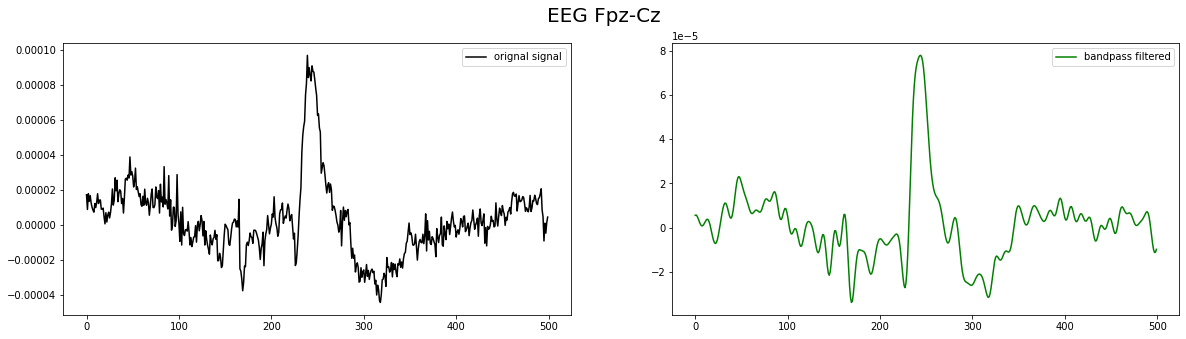

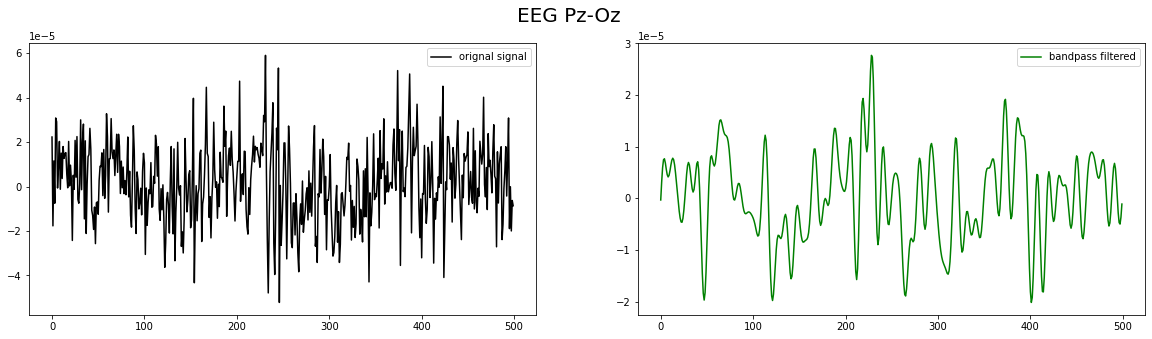

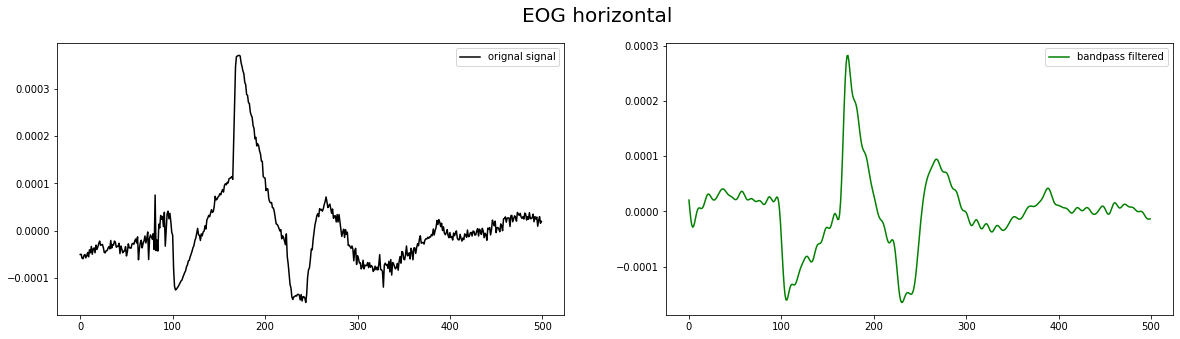

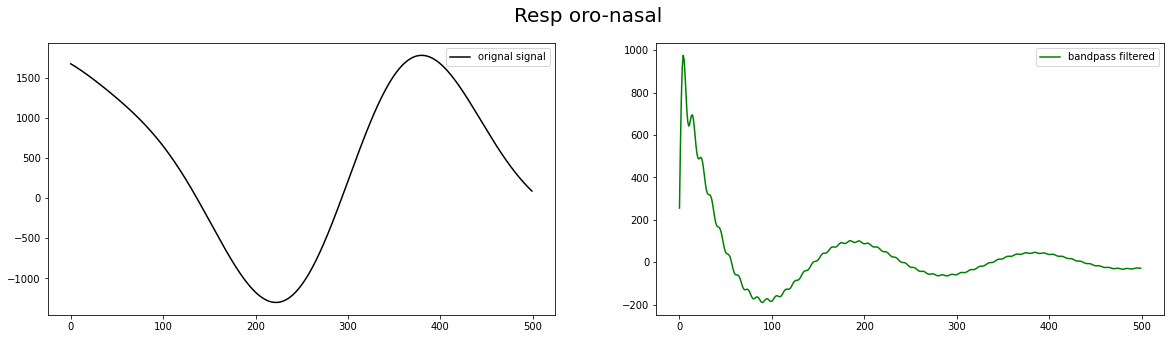

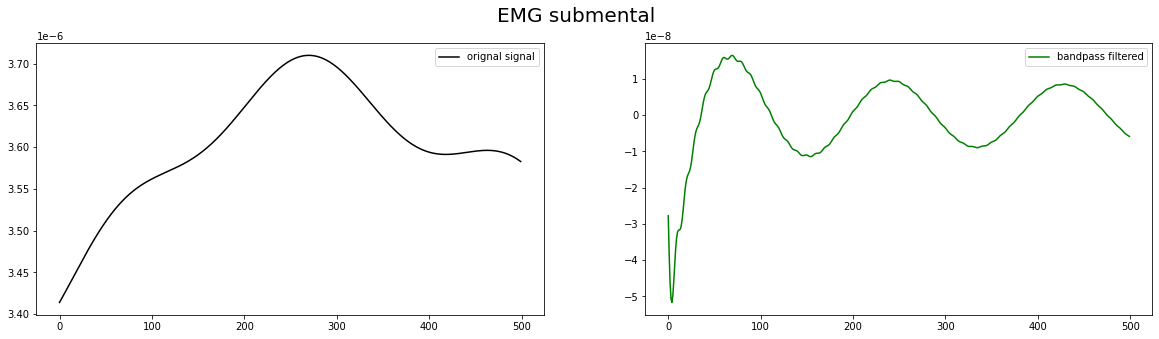

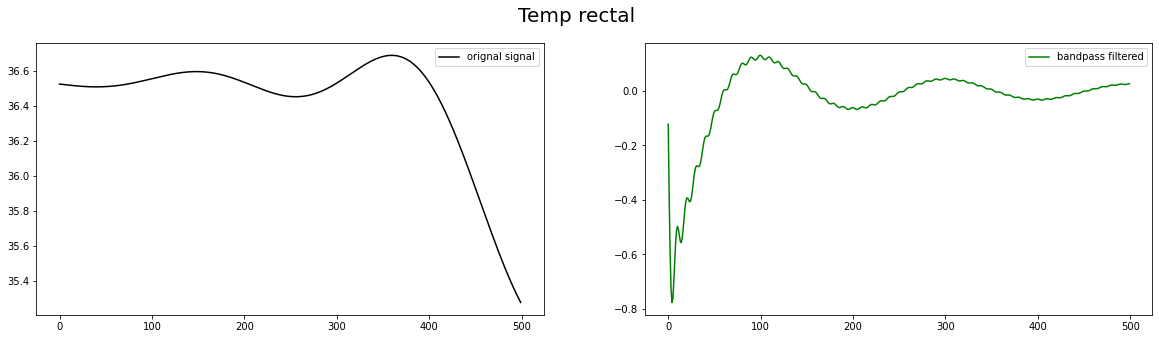

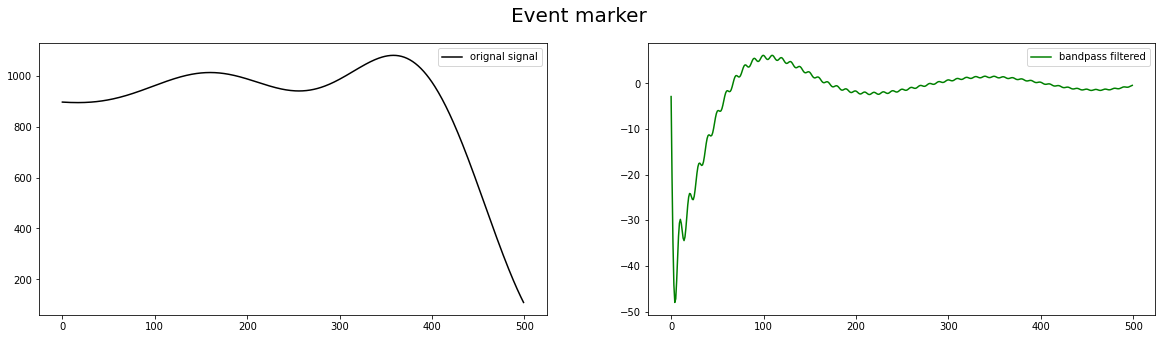

In [56]:
till = 500
for d, ch in zip(data[key].get_data(), channels):
  plt.figure(figsize=(20, 5))
  plt.suptitle(ch, fontsize=20)
  plt.subplot(121)
  plt.plot(d[:till], color='k', label='orignal signal')
  plt.legend()
  plt.subplot(122)
  plt.plot(bandpass_filter(d, sf=100, lower_limit=0.5, upper_limit=10)[:till], color='g', label='bandpass filtered')
  plt.legend()
  plt.show()

## Observation
With bandpass filter of lower cutoff = 0.5Hz and upper cutoff = 10Hz, fitered signals for last 4 channels (Resp oro-nasal, EMG submental, Temp rectal and Event marker) are very similar.

It implies that these 4 channels have similar amount of frequency component between 0.5Hz to 10Hz

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Loading the dataset for training the model

In [ ]:
!python prepare_physionet.py --data_dir data --output_dir data/eeg_fpz_cz --select_ch 'EEG Fpz-Cz'

## Training the model

In [ ]:
!python train.py --data_dir data/eeg_fpz_cz --output_dir output --n_folds 2 --fold_idx 0 --pretrain_epochs 1 --finetune_epochs 1 --resume False

In [ ]:
!chmod +x batch_train.sh
!./batch_train.sh data/eeg_fpz_cz/ output 2 0 1 0


## Making predictions

In [73]:
!python predict.py --data_dir data/eeg_fpz_cz --model_dir output --output_dir output

2021-10-10 15:42:05.165186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-10 15:42:05.189758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 15:42:05.190492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2021-10-10 15:42:05.190907: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-10 15:42:05.193009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-10 15:42:05.194336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
20

## Visualizing the hypnogram (sleep stage plot) for different subjects predicted by model and experts.

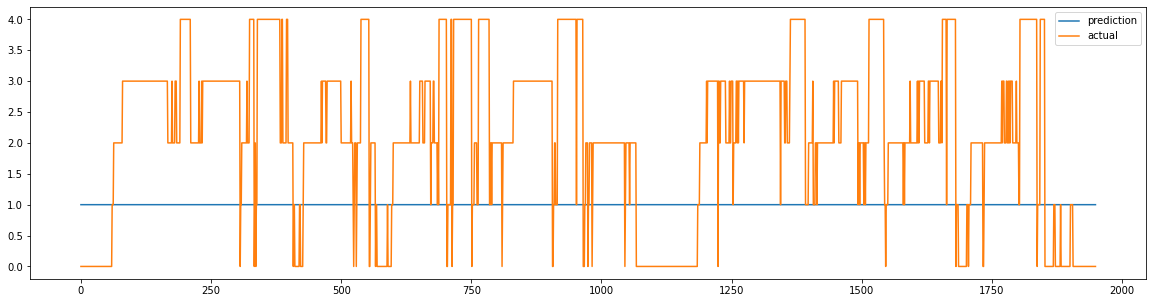

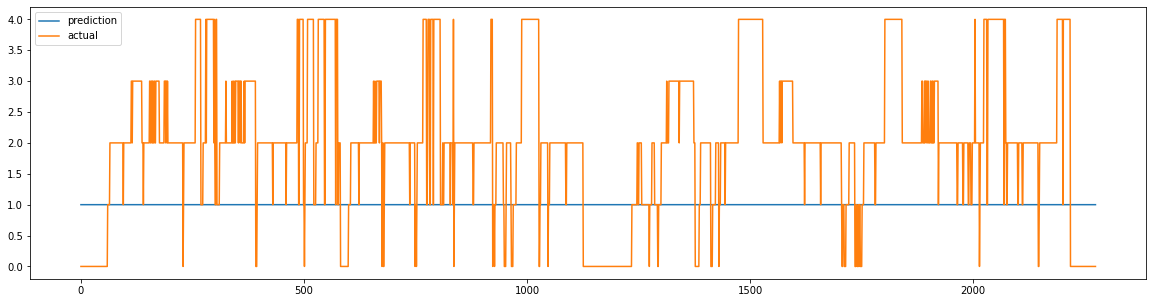

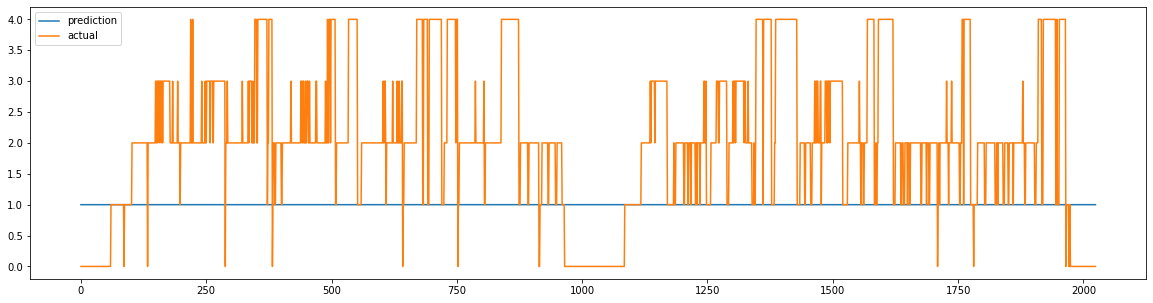

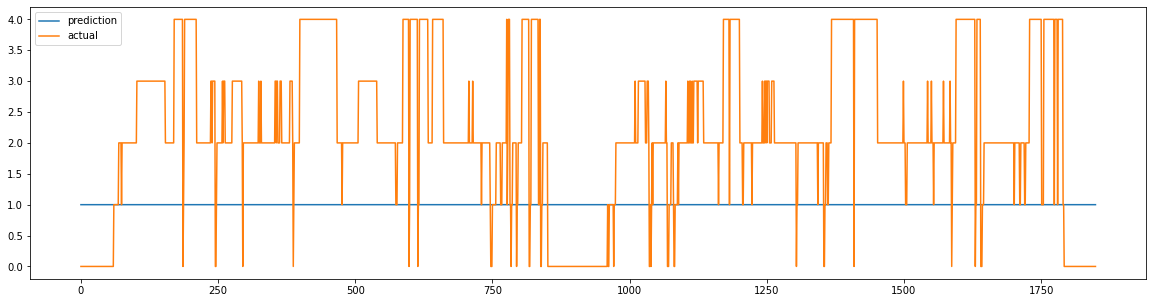

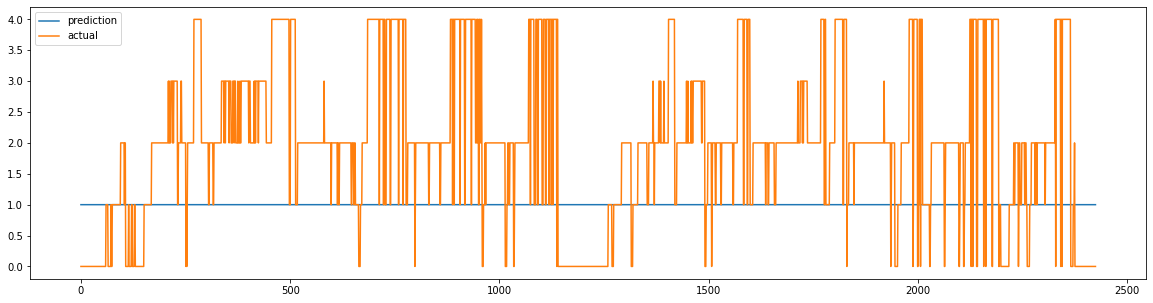

In [100]:
b = np.load('/content/deepsleepnet/output_signal.npy', allow_pickle=True)

for subject in range(5):
  plt.figure(figsize=(20, 5))
  plt.plot(b[0][subject], label='prediction')
  plt.plot(b[1][subject], label='actual')
  plt.legend()
  plt.show()


**It can be seen that model is biased to class 1**

### Output for different subjects is stored in
deepsleepnet --> data --> output

## Summary of model

In [72]:
!python summary.py --data_dir output

(2,)
File: output/output_subject0.npz
summary.py:20: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / tpfp
Sample: 1950
W: 353.0
N1: 117.0
N2: 623.0
N3: 517.0
REM: 340.0
Confusion matrix:
[[  0 353   0   0   0]
 [  0 117   0   0   0]
 [  0 623   0   0   0]
 [  0 517   0   0   0]
 [  0 340   0   0   0]]
Precision: [ nan 0.06  nan  nan  nan]
Recall: [0. 1. 0. 0. 0.]
F1: [       nan 0.11320755        nan        nan        nan]
Overall accuracy: 0.06
Macro-F1 accuracy: nan
(2,)
File: output/output_subject1.npz
Sample: 2275
W: 305.0
N1: 201.0
N2: 1222.0
N3: 201.0
REM: 346.0
Confusion matrix:
[[   0  305    0    0    0]
 [   0  201    0    0    0]
 [   0 1222    0    0    0]
 [   0  201    0    0    0]
 [   0  346    0    0    0]]
Precision: [       nan 0.08835165        nan        nan        nan]
Recall: [0. 1. 0. 0. 0.]
F1: [       nan 0.16235864        nan        nan        nan]
Overall accuracy: 0.08835164835164835
Macro-F1 accuracy: nan
(2,)
File: output/outpu

**Performance is very poor because the model is trained for very few iterations**